In [0]:
dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/cf_prophet.csv

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Cost Forecasting with Prophet") \
    .getOrCreate()

In [0]:
file_path = "dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/cf_prophet.csv"  # Adjust this path
data_df = spark.read.csv(file_path, header=True, inferSchema=True)
data_df.show()

+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+-----+-----------+---------------------+-------------------------+
|    HostItemID|  Cost|  List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|    Month|Sales|Lag_1|HolidayFlag|InventoryDiff_Reorder|InventoryDiff_SafetyStock|
+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+-----+-----------+---------------------+-------------------------+
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021|  January|   39|  NaN|          0|                  110|                       70|
|PMP*14680*2541| 385.0|873.72|   184|          17|  2021

In [0]:
import pandas as pd
pandas_df = data_df.toPandas()
pandas_df['LastSaleDate'] = pd.to_datetime(pandas_df['LastSaleDate'])
prophet_df = pandas_df[['LastSaleDate', 'Cost']].rename(columns={'LastSaleDate': 'ds', 'Cost': 'y'})
prophet_df = prophet_df.sort_values('ds').reset_index(drop=True)
print(prophet_df.head())

          ds       y
0 2021-04-17  381.96
1 2021-04-17  385.00
2 2021-04-17  390.50
3 2021-04-17  395.75
4 2021-04-17  400.00


In [0]:
train_size = len(prophet_df) - 12  
train_df = prophet_df[:train_size]
test_df = prophet_df[train_size:]
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 16, Test size: 12


In [0]:
from prophet import Prophet
model = Prophet()
model.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5c12bjgo/q5_vd0mu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5c12bjgo/zpinoad5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/local_disk0/.ephemeral_nfs/envs/pythonEnv-3a828105-a911-4fa7-a991-d84c4758af84/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31852', 'data', 'file=/tmp/tmp5c12bjgo/q5_vd0mu.json', 'init=/tmp/tmp5c12bjgo/zpinoad5.json', 'output', 'file=/tmp/tmp5c12bjgo/prophet_modeli0opignp/prophet_model-20241007181929.csv', 'method=optimize', 'algorithm=newton', 'ite

Out[10]: <prophet.forecaster.Prophet at 0x7f3bd24b4e50>

In [0]:
future = model.make_future_dataframe(periods=len(test_df), freq='M')
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test_df)))

           ds        yhat  yhat_lower  yhat_upper
2  2022-04-30  480.300308  459.579410  498.789615
3  2022-05-31  486.233710  467.178803  507.500890
4  2022-06-30  491.975712  472.848070  511.881193
5  2022-07-31  497.909114  478.634910  517.230482
6  2022-08-31  503.842516  484.002039  524.473371
7  2022-09-30  509.584517  490.514296  528.097204
8  2022-10-31  515.517919  495.252920  534.766682
9  2022-11-30  521.259921  501.313349  540.793709
10 2022-12-31  527.193323  507.446158  545.512700
11 2023-01-31  533.126725  513.908775  552.730642
12 2023-02-28  538.485927  519.863529  558.784489
13 2023-03-31  544.419329  524.482168  563.901072


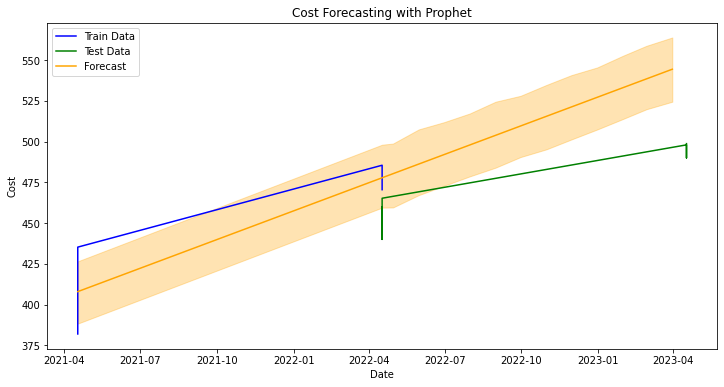

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Train Data', color='blue')
plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='green')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)
plt.title('Cost Forecasting with Prophet')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
forecasted_values = forecast['yhat'].tail(len(test_df)).values
actual_values = test_df['y'].values
mae = mean_absolute_error(actual_values, forecasted_values)
mse = mean_squared_error(actual_values, forecasted_values)
rmse = mean_squared_error(actual_values, forecasted_values, squared=False)  # squared=False gives RMSE
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 31.34
Mean Squared Error (MSE): 1117.87
Root Mean Squared Error (RMSE): 33.43


In [0]:
!pip install mlflow

  Using cached mlflow-2.16.2-py3-none-any.whl (26.7 MB)
  Using cached SQLAlchemy-2.0.35-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached graphene-3.3-py2.py3-none-any.whl (128 kB)
  Using cached docker-7.1.0-py3-none-any.whl (147 kB)
  Using cached flask-3.0.3-py3-none-any.whl (101 kB)
  Using cached gunicorn-23.0.0-py3-none-any.whl (85 kB)
  Using cached Markdown-3.7-py3-none-any.whl (106 kB)
  Using cached alembic-1.13.3-py3-none-any.whl (233 kB)
  Using cached mlflow_skinny-2.16.2-py3-none-any.whl (5.6 MB)
  Using cached sqlparse-0.5.1-py3-none-any.whl (44 kB)
  Using cached opentelemetry_api-1.27.0-py3-none-any.whl (63 kB)
  Using cached opentelemetry_sdk-1.27.0-py3-none-any.whl (110 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
  Using cached importlib_metadata-8.5.0-py3-none-any.whl (26 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (737 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl 

In [0]:
import mlflow
import mlflow.pyfunc

class ProphetWrapper(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        self.model = model

    def predict(self, context, model_input):
        return self.model.predict(model_input)
with mlflow.start_run():
    mlflow.pyfunc.log_model("Prophet_Model", python_model=ProphetWrapper())
    mlflow.log_param("model_type", "Prophet")
    mlflow.log_param("train_size", len(train_df))
    mlflow.log_param("test_size", len(test_df))

mlflow.end_run()

2024/10/07 18:21:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-da72b-042c6-492a/tmptfg16kel/model, flavor: python_function). Fall back to return ['cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/10/07 18:21:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

2024/10/07 18:21:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run rogue-lynx-420 at: https://community.cloud.databricks.com/ml/experiments/4498943658610035/runs/bc3c389586d74117a38e4dc4cfde9304.
2024/10/07 18:21:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/4498943658610035.
